In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch


In [ ]:
covid_directory = f'/content/gdrive/MyDrive/New Images for Classification/COVID-19'
normal_directory = f'/content/gdrive/MyDrive/New Images for Classification/Normal'
pneumonia_directory = f'/content/gdrive/MyDrive/New Images for Classification/Pneumonia'

image_size = (224, 224)

def load_images(directory):
    class_images = []
    for filename in os.listdir(directory):
        image_path = os.path.join(directory, filename)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        resized_image = cv2.resize(image, image_size)
        resized_image = resized_image.astype(np.float32)
        normalized_image = resized_image / 255.0
        class_images.append(normalized_image)

    return np.array(class_images)

covid_images = load_images(covid_directory)
normal_images = load_images(normal_directory)
pneumonia_images = load_images(pneumonia_directory)

print(covid_images.shape)
print(normal_images.shape)
print(pneumonia_images.shape)

(522, 224, 224, 3)
(1017, 224, 224, 3)
(1197, 224, 224, 3)


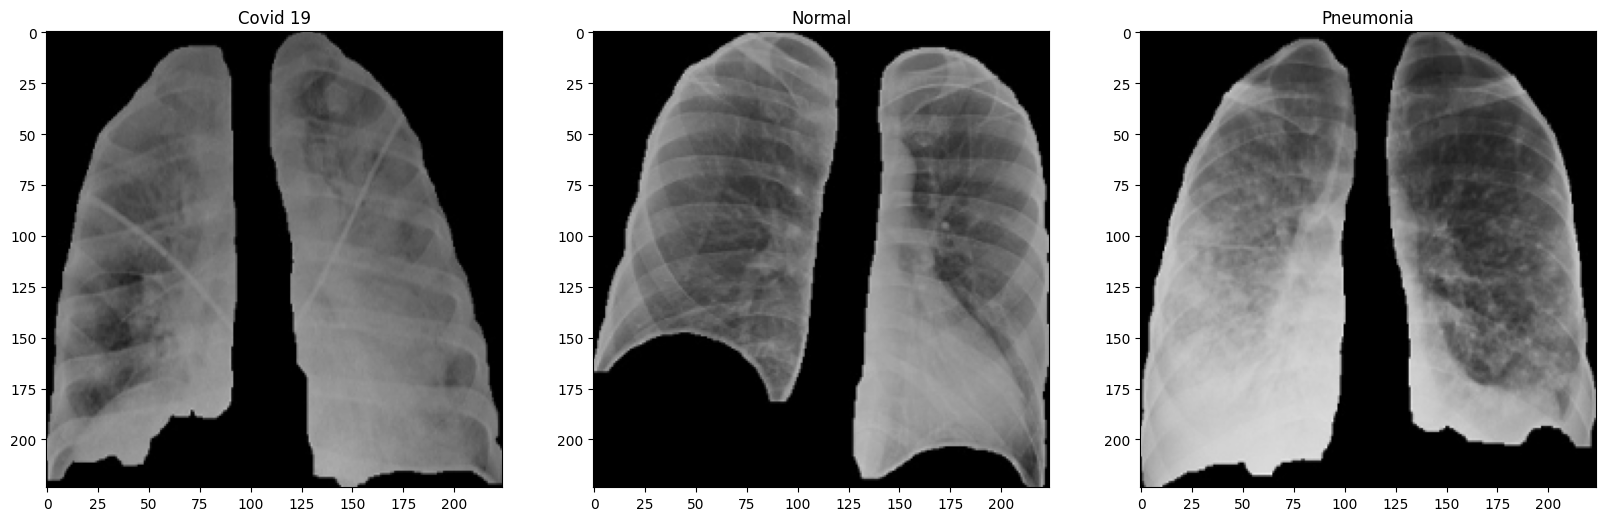

In [ ]:
fig, ax = plt.subplots(ncols=3, figsize = (20,20))
ax[0].imshow(covid_images[0])
ax[0].title.set_text("Covid 19")
ax[1].imshow(normal_images[0])
ax[1].title.set_text("Normal")
ax[2].imshow(pneumonia_images[0])
ax[2].title.set_text("Pneumonia")

In [ ]:
all_images = np.concatenate((covid_images, normal_images, pneumonia_images), axis=0)
print(all_images.shape)
covid_labels = np.zeros(len(covid_images), dtype=np.int32)
pneumonia_labels = np.ones(len(pneumonia_images), dtype=np.int32)
normal_labels = np.full(len(normal_images), 2, dtype=np.int32)

all_labels = np.concatenate((covid_labels, normal_labels, pneumonia_labels), axis=0)
print(all_labels.shape)

(2736, 224, 224, 3)
(2736,)


In [ ]:
from imblearn.over_sampling import SMOTE
from collections import Counter

class_counts = Counter(all_labels)
minority_class = min(class_counts, key=class_counts.get)
desired_ratio = dict(Counter(class_counts))
desired_ratio[minority_class] = len(all_images) // len(class_counts)
sm = SMOTE(sampling_strategy = desired_ratio, random_state=42)
flattened_images = all_images.reshape(all_images.shape[0], -1)
resampled_images, resampled_labels = sm.fit_resample(flattened_images, all_labels)

In [ ]:
original_shape = all_images.shape[1:]
new_images_res = resampled_images.reshape(-1, *original_shape)
print(new_images_res.shape)

(3126, 224, 224, 3)


In [ ]:
class_counts_resampled = Counter(resampled_labels)
print(class_counts_resampled)

Counter({1: 1197, 2: 1017, 0: 912})


In [ ]:
train_val_split, test_split = 0.8, 0.2
X_train_val, X_test, y_train_val, y_test = train_test_split(new_images_res, resampled_labels, train_size = train_val_split, test_size = test_split, random_state=42, stratify=resampled_labels)
train_split, val_split = 0.9, 0.1
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, train_size=train_split, test_size=val_split, random_state=42, stratify=y_train_val)


In [ ]:
import torch
torch.save(X_test, '/content/gdrive/MyDrive/X_test.pt')
torch.save(y_test, '/content/gdrive/MyDrive/y_test.pt')

In [ ]:
import torchvision
import torch

In [ ]:
from torchvision.models import densenet161
from torch import nn

model_dn161 = densenet161(weights='DEFAULT')

input_features = model_dn161.classifier.in_features
model_dn161.classifier = nn.Sequential(
        nn.Dropout(p=0.5),
        nn.Linear(input_features, 3),
        nn.Softmax(dim=1)
    )

model_dn161.load_state_dict(torch.load('/content/gdrive/MyDrive/Model Checkpoints and metrics for Dataset #2 (New)/densenet161_complete_saved.pt', map_location=torch.device('cpu')))
model_dn161.eval()

Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/hub/checkpoints/densenet161-8d451a50.pth
100%|██████████| 110M/110M [00:00<00:00, 127MB/s]


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [ ]:
from torchvision.models import resnet18
from torch import nn

model_rn18 = resnet18(weights='DEFAULT')

input_features = model_rn18.fc.in_features
model_rn18.fc = nn.Linear(input_features, 3)
model_rn18.fc = nn.Sequential(nn.Dropout(p=0.5), model_rn18.fc, nn.Softmax(dim=1))

model_rn18.load_state_dict(torch.load('/content/gdrive/MyDrive/Model Checkpoints and metrics for Dataset #2 (New)/resnet18_complete_saved.pt', map_location=torch.device('cpu')))
model_rn18.eval()

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 138MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
from torchvision.models import resnet34
from torch import nn

model_rn34 = resnet34(weights='DEFAULT')

input_features = model_rn34.fc.in_features
model_rn34.fc = nn.Sequential(
        nn.Dropout(p=0.6),
        nn.Linear(input_features, 3),
        nn.Softmax(dim=1)
    )

model_rn34.load_state_dict(torch.load('/content/gdrive/MyDrive/Model Checkpoints and metrics for Dataset #2 (New)/resnet34_complete_saved.pt', map_location=torch.device('cpu')))
model_rn34.eval()

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 140MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
print(y_test[7], y_test[10], y_test[1])

2 1 0


In [ ]:
print(y_test[44], y_test[26], y_test[25])

2 1 0


In [ ]:
normal = torch.from_numpy(X_test[44])
print(normal.max(), normal.min())
normal = torch.unsqueeze(normal,dim=0).permute(0,3,1,2)
print(normal.shape)

tensor(0.9529) tensor(0.)
torch.Size([1, 3, 224, 224])


In [ ]:
outputs = model_dn161(normal)
print(outputs)
print(torch.argmax(outputs,dim=1))

tensor([[3.0506e-04, 2.6717e-04, 9.9943e-01]], grad_fn=<SoftmaxBackward0>)
tensor([2])


In [ ]:
pneumonia = torch.from_numpy(X_test[26])
print(pneumonia.max(), pneumonia.min())
pneumonia = torch.unsqueeze(pneumonia,dim=0).permute(0,3,1,2)
print(pneumonia.shape)

tensor(0.9020) tensor(0.)
torch.Size([1, 3, 224, 224])


In [ ]:
outputs = model_dn161(pneumonia)
print(outputs)
print(torch.argmax(outputs,dim=1))

tensor([[0.0555, 0.9355, 0.0090]], grad_fn=<SoftmaxBackward0>)
tensor([1])


In [ ]:
covid = torch.from_numpy(X_test[25])
print(covid.max(), covid.min())
covid = torch.unsqueeze(covid,dim=0).permute(0,3,1,2)
print(covid.shape)

tensor(0.8078) tensor(0.)
torch.Size([1, 3, 224, 224])


In [ ]:
outputs = model_dn161(covid)
print(outputs)
print(torch.argmax(outputs,dim=1))

tensor([[0.9776, 0.0102, 0.0122]], grad_fn=<SoftmaxBackward0>)
tensor([0])


In [ ]:
outputs = model_rn34(normal)
print(outputs)
print(torch.argmax(outputs,dim=1))

tensor([[3.8516e-05, 9.3582e-06, 9.9995e-01]], grad_fn=<SoftmaxBackward0>)
tensor([2])


In [ ]:
outputs = model_rn34(pneumonia)
print(outputs)
print(torch.argmax(outputs,dim=1))

tensor([[2.1486e-02, 9.7815e-01, 3.6790e-04]], grad_fn=<SoftmaxBackward0>)
tensor([1])


In [ ]:
outputs = model_rn34(covid)
print(outputs)
print(torch.argmax(outputs,dim=1))

tensor([[1.0000e+00, 9.3132e-09, 1.4283e-07]], grad_fn=<SoftmaxBackward0>)
tensor([0])


In [ ]:
outputs = model_rn18(normal)
print(outputs)
print(torch.argmax(outputs,dim=1))

tensor([[8.9086e-05, 4.2512e-06, 9.9991e-01]], grad_fn=<SoftmaxBackward0>)
tensor([2])


In [ ]:
outputs = model_rn18(pneumonia)
print(outputs)
print(torch.argmax(outputs,dim=1))

tensor([[1.2291e-03, 9.9876e-01, 1.2421e-05]], grad_fn=<SoftmaxBackward0>)
tensor([1])


In [ ]:
outputs = model_rn18(covid)
print(outputs)
print(torch.argmax(outputs,dim=1))

tensor([[9.9922e-01, 5.0039e-04, 2.7628e-04]], grad_fn=<SoftmaxBackward0>)
tensor([0])


In [ ]:
!pip install captum
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 23.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylin

In [ ]:
import numpy as np
import torch
import torchvision
import cv2
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
X_test = torch.load('/content/gdrive/MyDrive/X_test.pt')
y_test = torch.load('/content/gdrive/MyDrive/y_test.pt')

# **Saliency and GradCAM for both batches of images**

In [ ]:
import cv2

In [ ]:
normal_1 = X_test[44]
normal_1 = torch.from_numpy(normal_1)
normal_1 = normal_1.type(torch.FloatTensor)
normal_1 = torch.unsqueeze(normal_1, dim=0).permute(0,3,1,2)

In [ ]:
print(normal_1, normal_1.dtype)

tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.5020, 0.6471, 0.6667],
          [0.0000, 0.0000, 0.0000,  ..., 0.4627, 0.6353, 0.6549],
          [0.0000, 0.0000, 0.0000,  ..., 0.4196, 0.6235, 0.6431]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.5020, 0.6471, 0.6667],
          [0.0000, 0.0000, 0.0000,  ..., 0.4627, 0.6353, 0.6549],
          [0.0000, 0.0000, 0.0000,  ..., 0.4196, 0.6235, 0.6431]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0

In [ ]:
import captum
from captum.attr import Saliency

In [ ]:
saliency = Saliency(model_dn161)
attributions = saliency.attribute(normal_1, target=2)

/usr/local/lib/python3.10/dist-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


In [ ]:
print(attributions)

tensor([[[[9.4282e-04, 1.2662e-03, 1.0037e-03,  ..., 2.8058e-04,
           0.0000e+00, 0.0000e+00],
          [5.8275e-04, 8.2659e-04, 1.0897e-03,  ..., 2.1405e-04,
           0.0000e+00, 0.0000e+00],
          [6.1243e-05, 6.4598e-04, 1.2249e-03,  ..., 1.1559e-04,
           0.0000e+00, 0.0000e+00],
          ...,
          [1.6482e-04, 1.8423e-04, 1.5411e-04,  ..., 2.1352e-05,
           2.6146e-04, 2.2500e-04],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 7.8632e-05,
           8.9213e-05, 3.3435e-05],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 4.1135e-05,
           6.1370e-05, 8.4489e-05]],

         [[2.0440e-04, 4.4004e-04, 3.9262e-04,  ..., 2.5105e-04,
           0.0000e+00, 0.0000e+00],
          [1.1935e-04, 1.3952e-04, 6.0077e-04,  ..., 4.6271e-04,
           0.0000e+00, 0.0000e+00],
          [1.2216e-05, 3.8150e-04, 9.9845e-04,  ..., 5.4767e-04,
           0.0000e+00, 0.0000e+00],
          ...,
          [5.6678e-05, 3.1105e-07, 3.7313e-05,  ..., 1.3285

In [ ]:
import captum
normal_1 = torch.squeeze(normal_1, dim=0)
normal_1 = normal_1.permute(1,2,0)
attributions = torch.squeeze(attributions, dim=0).permute(1,2,0)
print(normal_1.shape, attributions.shape)

torch.Size([224, 224, 3]) torch.Size([224, 224, 3])


In [ ]:
attributions = attributions.numpy()
normal_1 = normal_1.numpy()


In [ ]:
attributions = (attributions - attributions.min()) / (attributions.max() - attributions.min())


In [ ]:
print(attributions.shape)

(224, 224, 3)


In [ ]:
import matplotlib.pyplot as plt

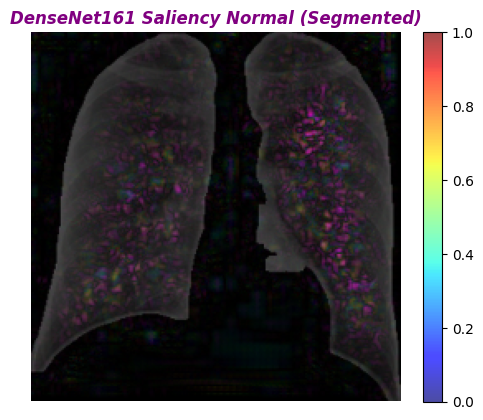

In [ ]:
plt.imshow(normal_1)
plt.imshow(attributions, cmap='jet', alpha=0.7)
plt.colorbar(fraction=0.06, pad=0.046, orientation='vertical')
plt.title("DenseNet161 Saliency Normal (Segmented)", color='purple', weight='bold', style='oblique')
plt.axis('off')
plt.show()

In [ ]:
covid_1 = X_test[25]
covid_1 = torch.from_numpy(covid_1)
covid_1 = covid_1.type(torch.FloatTensor)
covid_1 = torch.unsqueeze(covid_1, dim=0).permute(0,3,1,2)

In [ ]:
print(covid_1.dtype, covid_1.shape)

torch.float32 torch.Size([1, 3, 224, 224])


In [ ]:
saliency = Saliency(model_dn161)
attributions = saliency.attribute(covid_1, target=0)

In [ ]:
print(attributions)

tensor([[[[2.0567e-03, 1.5589e-04, 1.5298e-02,  ..., 1.1752e-02,
           0.0000e+00, 0.0000e+00],
          [1.3624e-03, 7.8137e-03, 3.0526e-03,  ..., 8.7107e-03,
           0.0000e+00, 0.0000e+00],
          [1.4584e-02, 3.2431e-03, 3.6713e-02,  ..., 9.1784e-03,
           0.0000e+00, 0.0000e+00],
          ...,
          [1.1853e-03, 9.4593e-04, 8.2917e-04,  ..., 2.2063e-03,
           6.6836e-04, 9.2518e-04],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 1.7759e-03,
           6.9110e-04, 4.6544e-04],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 1.4870e-03,
           2.4746e-04, 4.3325e-05]],

         [[5.1929e-02, 4.1124e-02, 3.5678e-02,  ..., 6.4804e-03,
           0.0000e+00, 0.0000e+00],
          [8.6148e-02, 9.0695e-02, 6.1939e-02,  ..., 1.6267e-02,
           0.0000e+00, 0.0000e+00],
          [1.2613e-01, 1.2280e-01, 5.3568e-02,  ..., 2.8161e-02,
           0.0000e+00, 0.0000e+00],
          ...,
          [1.6284e-04, 2.6781e-04, 1.0533e-03,  ..., 1.6027

In [ ]:
import captum
covid_1 = torch.squeeze(covid_1, dim=0)
covid_1 = covid_1.permute(1,2,0)
attributions = torch.squeeze(attributions, dim=0).permute(1,2,0)
print(covid_1.shape, attributions.shape)

torch.Size([224, 224, 3]) torch.Size([224, 224, 3])


In [ ]:
attributions = attributions.numpy()
covid_1 = covid_1.numpy()


In [ ]:
attributions = (attributions - attributions.min()) / (attributions.max() - attributions.min())


In [ ]:
print(attributions.shape)

(224, 224, 3)


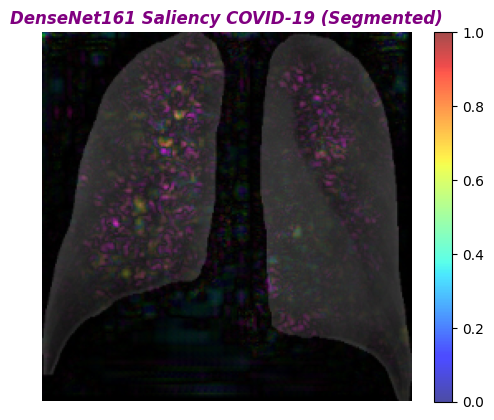

In [ ]:
plt.imshow(covid_1)
plt.imshow(attributions, cmap='jet', alpha=0.7)
plt.colorbar(fraction=0.06, pad=0.046, orientation='vertical')
plt.title("DenseNet161 Saliency COVID-19 (Segmented)", color='purple', weight='bold', style='oblique')
plt.axis('off')
plt.show()

In [ ]:
pneumonia_1 = X_test[26]
pneumonia_1 = torch.from_numpy(pneumonia_1)
pneumonia_1 = pneumonia_1.type(torch.FloatTensor)
pneumonia_1 = torch.unsqueeze(pneumonia_1, dim=0).permute(0,3,1,2)

In [ ]:
print(pneumonia_1.dtype, pneumonia_1.shape)

torch.float32 torch.Size([1, 3, 224, 224])


In [ ]:
saliency = Saliency(model_dn161)
attributions = saliency.attribute(pneumonia_1, target=1)

In [ ]:
print(attributions)

tensor([[[[0.0112, 0.0123, 0.0269,  ..., 0.0119, 0.0000, 0.0000],
          [0.0494, 0.0429, 0.0112,  ..., 0.0118, 0.0000, 0.0000],
          [0.0351, 0.0092, 0.0192,  ..., 0.0056, 0.0000, 0.0000],
          ...,
          [0.0206, 0.0246, 0.0289,  ..., 0.0004, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0795, 0.0390, 0.0132,  ..., 0.0131, 0.0000, 0.0000],
          [0.0985, 0.0885, 0.0374,  ..., 0.0170, 0.0000, 0.0000],
          [0.0397, 0.0228, 0.0238,  ..., 0.0118, 0.0000, 0.0000],
          ...,
          [0.0019, 0.0206, 0.0347,  ..., 0.0050, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0153, 0.0163, 0.0274,  ..., 0.0221, 0.0000, 0.0000],
          [0.0027, 0.0126, 0.0301,  ..., 0.0256, 0.0000, 0.0000],
          [0.0422, 0.0497, 0.0265,  ..., 0

In [ ]:
import captum
pneumonia_1 = torch.squeeze(pneumonia_1, dim=0)
pneumonia_1 = pneumonia_1.permute(1,2,0)
attributions = torch.squeeze(attributions, dim=0).permute(1,2,0)
print(pneumonia_1.shape, attributions.shape)

torch.Size([224, 224, 3]) torch.Size([224, 224, 3])


In [ ]:
attributions = attributions.numpy()
pneumonia_1 = pneumonia_1.numpy()


In [ ]:
attributions = (attributions - attributions.min()) / (attributions.max() - attributions.min())


In [ ]:
print(attributions.shape)

(224, 224, 3)


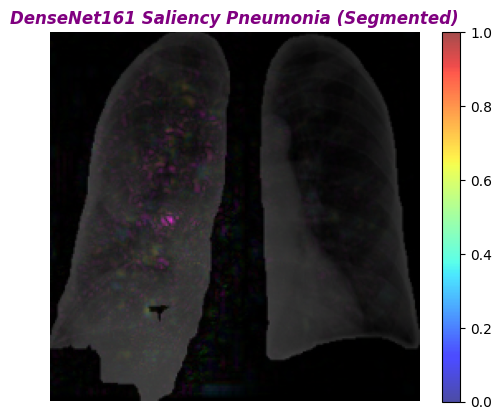

In [ ]:
plt.imshow(pneumonia_1)
plt.imshow(attributions, cmap='jet', alpha=0.7)
plt.colorbar(fraction=0.06, pad=0.046, orientation='vertical')
plt.title("DenseNet161 Saliency Pneumonia (Segmented)", color='purple', weight='bold', style='oblique')
plt.axis('off')
plt.show()

In [ ]:
normal_1 = X_test[44]
normal_1 = torch.from_numpy(normal_1)
normal_1 = normal_1.type(torch.FloatTensor)
normal_1 = torch.unsqueeze(normal_1, dim=0).permute(0,3,1,2)

In [ ]:
print(normal_1, normal_1.dtype)

tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.5020, 0.6471, 0.6667],
          [0.0000, 0.0000, 0.0000,  ..., 0.4627, 0.6353, 0.6549],
          [0.0000, 0.0000, 0.0000,  ..., 0.4196, 0.6235, 0.6431]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.5020, 0.6471, 0.6667],
          [0.0000, 0.0000, 0.0000,  ..., 0.4627, 0.6353, 0.6549],
          [0.0000, 0.0000, 0.0000,  ..., 0.4196, 0.6235, 0.6431]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0

In [ ]:
saliency = Saliency(model_rn18)
attributions = saliency.attribute(normal_1, target=2)

In [ ]:
print(attributions)

tensor([[[[1.0712e-05, 2.7550e-05, 4.0702e-05,  ..., 1.2442e-06,
           0.0000e+00, 0.0000e+00],
          [1.8743e-05, 3.8712e-05, 5.2205e-05,  ..., 3.2498e-06,
           0.0000e+00, 0.0000e+00],
          [1.6565e-05, 3.7801e-05, 4.5400e-05,  ..., 3.6518e-06,
           0.0000e+00, 0.0000e+00],
          ...,
          [2.5952e-05, 2.3954e-05, 1.1939e-05,  ..., 5.4449e-05,
           5.2930e-05, 3.5040e-05],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 3.1526e-05,
           4.7077e-05, 4.6751e-05],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 3.2355e-05,
           5.1559e-05, 4.4357e-05]],

         [[1.7025e-07, 1.2004e-06, 1.1880e-07,  ..., 1.7322e-07,
           0.0000e+00, 0.0000e+00],
          [6.9896e-08, 1.0117e-06, 2.1696e-06,  ..., 1.5626e-06,
           0.0000e+00, 0.0000e+00],
          [1.1466e-05, 7.8765e-06, 5.5246e-06,  ..., 3.8770e-06,
           0.0000e+00, 0.0000e+00],
          ...,
          [9.0434e-06, 8.4819e-06, 1.9943e-06,  ..., 2.6022

In [ ]:
import captum
normal_1 = torch.squeeze(normal_1, dim=0)
normal_1 = normal_1.permute(1,2,0)
attributions = torch.squeeze(attributions, dim=0).permute(1,2,0)
print(normal_1.shape, attributions.shape)

torch.Size([224, 224, 3]) torch.Size([224, 224, 3])


In [ ]:
attributions = attributions.numpy()
normal_1 = normal_1.numpy()


In [ ]:
attributions = (attributions - attributions.min()) / (attributions.max() - attributions.min())


In [ ]:
print(attributions.shape)

(224, 224, 3)


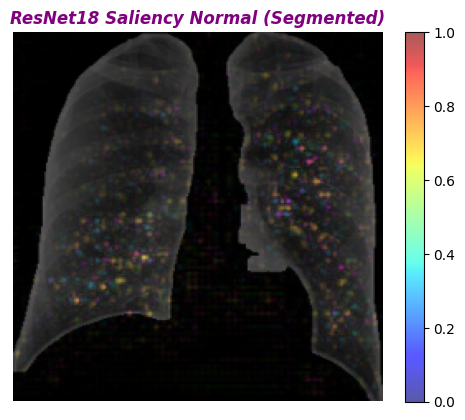

In [ ]:
plt.imshow(normal_1)
plt.imshow(attributions, cmap='jet', alpha=0.65)
plt.colorbar(fraction=0.06, pad=0.046, orientation='vertical')
plt.title("ResNet18 Saliency Normal (Segmented)", color='purple', weight='bold', style='oblique')
plt.axis('off')
plt.show()

In [ ]:
covid_1 = X_test[25]
covid_1 = torch.from_numpy(covid_1)
covid_1 = covid_1.type(torch.FloatTensor)
covid_1 = torch.unsqueeze(covid_1, dim=0).permute(0,3,1,2)

In [ ]:
print(covid_1.dtype, covid_1.shape)

torch.float32 torch.Size([1, 3, 224, 224])


In [ ]:
saliency = Saliency(model_rn18)
attributions = saliency.attribute(covid_1, target=0)

In [ ]:
print(attributions)

tensor([[[[6.0694e-04, 1.0057e-03, 1.1623e-03,  ..., 2.5299e-05,
           0.0000e+00, 0.0000e+00],
          [1.0444e-03, 1.4520e-03, 1.6158e-03,  ..., 6.2930e-05,
           0.0000e+00, 0.0000e+00],
          [1.3213e-03, 1.7978e-03, 1.6528e-03,  ..., 1.3943e-04,
           0.0000e+00, 0.0000e+00],
          ...,
          [2.2400e-04, 1.7773e-04, 3.8239e-06,  ..., 8.1564e-04,
           1.4004e-04, 2.1691e-04],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 9.4554e-04,
           3.3922e-04, 1.2361e-05],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 8.2738e-04,
           2.9319e-04, 4.3540e-05]],

         [[2.7512e-04, 3.0801e-04, 4.6772e-04,  ..., 8.4136e-06,
           0.0000e+00, 0.0000e+00],
          [2.2588e-04, 5.1471e-04, 6.3778e-04,  ..., 6.5279e-06,
           0.0000e+00, 0.0000e+00],
          [2.7024e-04, 5.2254e-04, 7.2700e-04,  ..., 4.8223e-05,
           0.0000e+00, 0.0000e+00],
          ...,
          [1.0835e-04, 1.3269e-04, 6.2972e-05,  ..., 1.9098

In [ ]:
import captum
covid_1 = torch.squeeze(covid_1, dim=0)
covid_1 = covid_1.permute(1,2,0)
attributions = torch.squeeze(attributions, dim=0).permute(1,2,0)
print(covid_1.shape, attributions.shape)

torch.Size([224, 224, 3]) torch.Size([224, 224, 3])


In [ ]:
attributions = attributions.numpy()
covid_1 = covid_1.numpy()


In [ ]:
attributions = (attributions - attributions.min()) / (attributions.max() - attributions.min())


In [ ]:
print(attributions.shape)

(224, 224, 3)


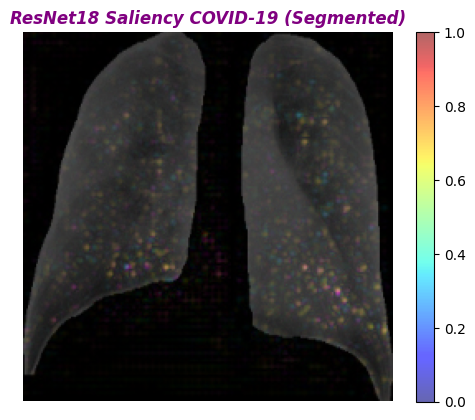

In [ ]:
plt.imshow(covid_1)
plt.imshow(attributions, cmap='jet', alpha=0.6)
plt.colorbar(fraction=0.06, pad=0.046, orientation='vertical')
plt.title("ResNet18 Saliency COVID-19 (Segmented)", color='purple', weight='bold', style='oblique')
plt.axis('off')
plt.show()

In [ ]:
pneumonia_1 = X_test[26]
pneumonia_1 = torch.from_numpy(pneumonia_1)
pneumonia_1 = pneumonia_1.type(torch.FloatTensor)
pneumonia_1 = torch.unsqueeze(pneumonia_1, dim=0).permute(0,3,1,2)

In [ ]:
print(pneumonia_1.dtype, pneumonia_1.shape)

torch.float32 torch.Size([1, 3, 224, 224])


In [ ]:
saliency = Saliency(model_rn18)
attributions = saliency.attribute(pneumonia_1, target=1)

In [ ]:
print(attributions)

tensor([[[[4.0461e-04, 4.4297e-04, 2.0984e-04,  ..., 5.1405e-05,
           0.0000e+00, 0.0000e+00],
          [5.5228e-04, 5.6768e-04, 2.7935e-04,  ..., 8.2073e-05,
           0.0000e+00, 0.0000e+00],
          [5.3227e-04, 5.5311e-04, 2.8047e-04,  ..., 1.5101e-04,
           0.0000e+00, 0.0000e+00],
          ...,
          [3.7158e-04, 1.6894e-04, 1.8825e-04,  ..., 3.2954e-04,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]],

         [[7.6084e-05, 1.4744e-04, 1.1431e-04,  ..., 3.3410e-05,
           0.0000e+00, 0.0000e+00],
          [6.5111e-05, 3.1842e-05, 3.2110e-06,  ..., 2.9226e-05,
           0.0000e+00, 0.0000e+00],
          [1.0348e-04, 2.0169e-04, 2.1035e-04,  ..., 6.5820e-05,
           0.0000e+00, 0.0000e+00],
          ...,
          [8.8331e-05, 1.2262e-04, 6.7809e-05,  ..., 1.7114

In [ ]:
import captum
pneumonia_1 = torch.squeeze(pneumonia_1, dim=0)
pneumonia_1 = pneumonia_1.permute(1,2,0)
attributions = torch.squeeze(attributions, dim=0).permute(1,2,0)
print(pneumonia_1.shape, attributions.shape)

torch.Size([224, 224, 3]) torch.Size([224, 224, 3])


In [ ]:
attributions = attributions.numpy()
pneumonia_1 = pneumonia_1.numpy()


In [ ]:
attributions = (attributions - attributions.min()) / (attributions.max() - attributions.min())


In [ ]:
print(attributions.shape)

(224, 224, 3)


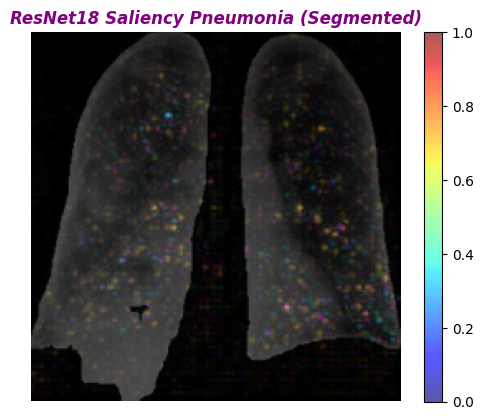

In [ ]:
plt.imshow(pneumonia_1)
plt.imshow(attributions, cmap='jet', alpha=0.65)
plt.colorbar(fraction=0.06, pad=0.046, orientation='vertical')
plt.title("ResNet18 Saliency Pneumonia (Segmented)", color='purple', weight='bold', style='oblique')
plt.axis('off')
plt.show()

In [ ]:
normal_1 = X_test[44]
normal_1 = torch.from_numpy(normal_1)
normal_1 = normal_1.type(torch.FloatTensor)
normal_1 = torch.unsqueeze(normal_1, dim=0).permute(0,3,1,2)

In [ ]:
print(normal_1, normal_1.dtype)

tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.5020, 0.6471, 0.6667],
          [0.0000, 0.0000, 0.0000,  ..., 0.4627, 0.6353, 0.6549],
          [0.0000, 0.0000, 0.0000,  ..., 0.4196, 0.6235, 0.6431]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.5020, 0.6471, 0.6667],
          [0.0000, 0.0000, 0.0000,  ..., 0.4627, 0.6353, 0.6549],
          [0.0000, 0.0000, 0.0000,  ..., 0.4196, 0.6235, 0.6431]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0

In [ ]:
saliency = Saliency(model_rn34)
attributions = saliency.attribute(normal_1, target=2)

In [ ]:
print(attributions)

tensor([[[[1.6476e-05, 2.3979e-05, 2.3952e-05,  ..., 1.8333e-06,
           0.0000e+00, 0.0000e+00],
          [1.9049e-05, 3.1598e-05, 3.2331e-05,  ..., 9.3805e-07,
           0.0000e+00, 0.0000e+00],
          [1.7971e-05, 2.5889e-05, 2.7734e-05,  ..., 1.6586e-06,
           0.0000e+00, 0.0000e+00],
          ...,
          [2.3490e-06, 2.8533e-06, 1.4376e-06,  ..., 5.8967e-06,
           9.8312e-07, 2.2230e-07],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 1.7480e-06,
           2.1601e-07, 6.5571e-08],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 1.6696e-06,
           6.1557e-07, 1.8038e-06]],

         [[2.6193e-05, 2.8732e-05, 2.2365e-05,  ..., 3.3886e-06,
           0.0000e+00, 0.0000e+00],
          [2.7207e-05, 2.3933e-05, 9.8955e-06,  ..., 4.2168e-06,
           0.0000e+00, 0.0000e+00],
          [3.1813e-06, 4.6670e-06, 2.5056e-05,  ..., 4.4491e-06,
           0.0000e+00, 0.0000e+00],
          ...,
          [1.3236e-07, 5.1555e-07, 2.1817e-06,  ..., 6.3084

In [ ]:
import captum
normal_1 = torch.squeeze(normal_1, dim=0)
normal_1 = normal_1.permute(1,2,0)
attributions = torch.squeeze(attributions, dim=0).permute(1,2,0)
print(normal_1.shape, attributions.shape)

torch.Size([224, 224, 3]) torch.Size([224, 224, 3])


In [ ]:
attributions = attributions.numpy()
normal_1 = normal_1.numpy()


In [ ]:
attributions = (attributions - attributions.min()) / (attributions.max() - attributions.min())


In [ ]:
print(attributions.shape)

(224, 224, 3)


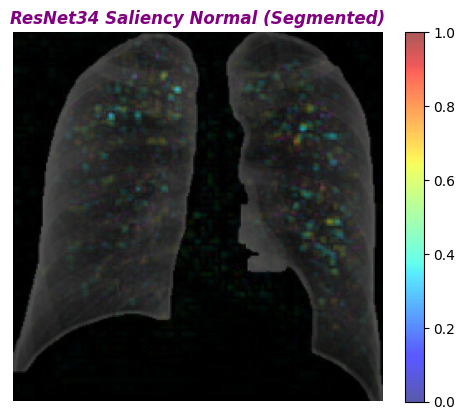

In [ ]:
plt.imshow(normal_1)
plt.imshow(attributions, cmap='jet', alpha=0.65)
plt.colorbar(fraction=0.06, pad=0.046, orientation='vertical')
plt.title("ResNet34 Saliency Normal (Segmented)", color='purple', weight='bold', style='oblique')
plt.axis('off')
plt.show()

In [ ]:
covid_1 = X_test[25]
covid_1 = torch.from_numpy(covid_1)
covid_1 = covid_1.type(torch.FloatTensor)
covid_1 = torch.unsqueeze(covid_1, dim=0).permute(0,3,1,2)

In [ ]:
print(covid_1.dtype, covid_1.shape)

torch.float32 torch.Size([1, 3, 224, 224])


In [ ]:
saliency = Saliency(model_rn34)
attributions = saliency.attribute(covid_1, target=0)

In [ ]:
print(attributions)

tensor([[[[5.7851e-10, 4.0861e-08, 4.7869e-08,  ..., 1.6374e-08,
           0.0000e+00, 0.0000e+00],
          [2.2709e-08, 5.5547e-08, 7.4933e-08,  ..., 8.9245e-09,
           0.0000e+00, 0.0000e+00],
          [2.1521e-08, 3.5334e-08, 6.6448e-08,  ..., 1.8650e-08,
           0.0000e+00, 0.0000e+00],
          ...,
          [1.0641e-09, 3.9775e-09, 8.2561e-09,  ..., 2.4670e-08,
           4.3171e-09, 9.2177e-09],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 7.7232e-09,
           4.5392e-09, 9.3568e-09],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 2.2953e-09,
           2.7129e-09, 6.7499e-09]],

         [[1.0640e-07, 1.0954e-07, 1.0511e-07,  ..., 1.9160e-08,
           0.0000e+00, 0.0000e+00],
          [6.0827e-08, 6.3933e-08, 2.0605e-08,  ..., 2.6621e-08,
           0.0000e+00, 0.0000e+00],
          [6.7706e-08, 1.1367e-07, 2.1358e-07,  ..., 1.0393e-08,
           0.0000e+00, 0.0000e+00],
          ...,
          [2.7044e-09, 3.7047e-09, 2.3909e-09,  ..., 4.8321

In [ ]:
import captum
covid_1 = torch.squeeze(covid_1, dim=0)
covid_1 = covid_1.permute(1,2,0)
attributions = torch.squeeze(attributions, dim=0).permute(1,2,0)
print(covid_1.shape, attributions.shape)

torch.Size([224, 224, 3]) torch.Size([224, 224, 3])


In [ ]:
attributions = attributions.numpy()
covid_1 = covid_1.numpy()


In [ ]:
attributions = (attributions - attributions.min()) / (attributions.max() - attributions.min())


In [ ]:
print(attributions.shape)

(224, 224, 3)


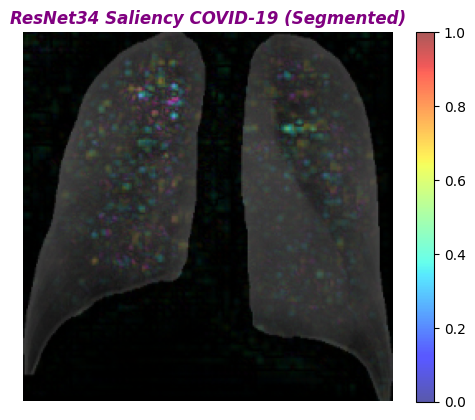

In [ ]:
plt.imshow(covid_1)
plt.imshow(attributions, cmap='jet', alpha=0.65)
plt.colorbar(fraction=0.06, pad=0.046, orientation='vertical')
plt.title("ResNet34 Saliency COVID-19 (Segmented)", color='purple', weight='bold', style='oblique')
plt.axis('off')
plt.show()

In [ ]:
pneumonia_1 = X_test[26]
pneumonia_1 = torch.from_numpy(pneumonia_1)
pneumonia_1 = pneumonia_1.type(torch.FloatTensor)
pneumonia_1 = torch.unsqueeze(pneumonia_1, dim=0).permute(0,3,1,2)

In [ ]:
print(pneumonia_1.dtype, pneumonia_1.shape)

torch.float32 torch.Size([1, 3, 224, 224])


In [ ]:
saliency = Saliency(model_rn34)
attributions = saliency.attribute(pneumonia_1, target=1)

In [ ]:
print(attributions)

tensor([[[[4.2696e-03, 6.0456e-03, 4.9970e-03,  ..., 1.0413e-03,
           0.0000e+00, 0.0000e+00],
          [5.6668e-03, 7.5801e-03, 8.0643e-03,  ..., 1.0273e-04,
           0.0000e+00, 0.0000e+00],
          [2.0232e-03, 5.8924e-03, 7.5295e-03,  ..., 4.8481e-04,
           0.0000e+00, 0.0000e+00],
          ...,
          [9.1730e-04, 1.2507e-03, 7.7912e-04,  ..., 2.2023e-04,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]],

         [[3.2816e-03, 4.5877e-03, 7.2487e-03,  ..., 9.8486e-04,
           0.0000e+00, 0.0000e+00],
          [2.3199e-03, 5.3678e-03, 8.1705e-03,  ..., 1.5455e-03,
           0.0000e+00, 0.0000e+00],
          [2.0970e-03, 2.8367e-03, 6.0038e-03,  ..., 1.0752e-03,
           0.0000e+00, 0.0000e+00],
          ...,
          [4.1318e-03, 5.4599e-03, 7.5117e-03,  ..., 3.3918

In [ ]:
import captum
pneumonia_1 = torch.squeeze(pneumonia_1, dim=0)
pneumonia_1 = pneumonia_1.permute(1,2,0)
attributions = torch.squeeze(attributions, dim=0).permute(1,2,0)
print(pneumonia_1.shape, attributions.shape)

torch.Size([224, 224, 3]) torch.Size([224, 224, 3])


In [ ]:
attributions = attributions.numpy()
pneumonia_1 = pneumonia_1.numpy()


In [ ]:
attributions = (attributions - attributions.min()) / (attributions.max() - attributions.min())


In [ ]:
print(attributions.shape)

(224, 224, 3)


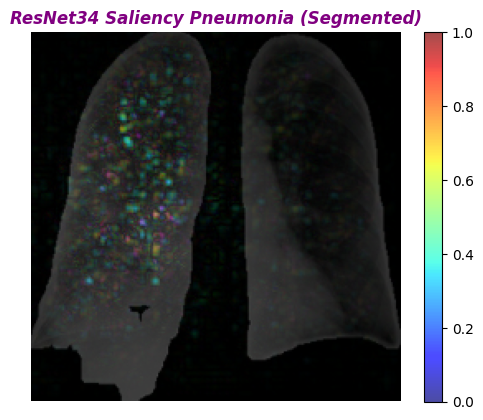

In [ ]:
plt.imshow(pneumonia_1)
plt.imshow(attributions, cmap='jet', alpha=0.7)
plt.colorbar(fraction=0.06, pad=0.046, orientation='vertical')
plt.title("ResNet34 Saliency Pneumonia (Segmented)", color='purple', weight='bold', style='oblique')
plt.axis('off')
plt.show()

In [ ]:
normal_1 = X_test[44]
normal_1 = torch.from_numpy(normal_1)
normal_1 = normal_1.type(torch.FloatTensor)
normal_1 = torch.unsqueeze(normal_1, dim=0).permute(0,3,1,2)

In [ ]:
from pytorch_grad_cam import GradCAM

target_layer = [model_dn161.features[-1]]

cam = GradCAM(model=model_dn161, target_layers=target_layer)

cam_map = cam(input_tensor=normal_1, eigen_smooth=True, aug_smooth=True)

print(cam_map)

[[[0.07253584 0.07253584 0.07253584 ... 0.         0.         0.        ]
  [0.07253584 0.07253584 0.07253584 ... 0.         0.         0.        ]
  [0.07253584 0.07253584 0.07253584 ... 0.         0.         0.        ]
  ...
  [0.15817375 0.15817375 0.15817375 ... 0.16415812 0.16415812 0.16415812]
  [0.15817375 0.15817375 0.15817375 ... 0.16415812 0.16415812 0.16415812]
  [0.15817375 0.15817375 0.15817375 ... 0.16415812 0.16415812 0.16415812]]]


In [ ]:
import numpy as np

In [ ]:
print(type(cam_map))
print(cam_map.shape)
cam_map = np.reshape(cam_map, (224,224,1))
print(cam_map.shape)

<class 'numpy.ndarray'>
(1, 224, 224)
(224, 224, 1)


In [ ]:
image_numpy = torch.squeeze(normal_1, dim=0).permute(1,2,0).numpy()
print(type(image_numpy), image_numpy.shape)

<class 'numpy.ndarray'> (224, 224, 3)


In [ ]:
import matplotlib.pyplot as plt

cam_map_normalized = (cam_map - np.min(cam_map)) / (np.max(cam_map) - np.min(cam_map))

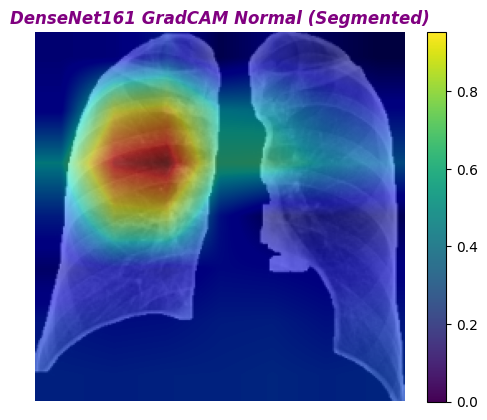

In [ ]:
fig, ax = plt.subplots()

heatmap = ax.imshow(image_numpy)

ax.imshow(cam_map_normalized, cmap='jet', alpha=0.5, interpolation='bilinear')
plt.colorbar(heatmap, fraction=0.06, pad=0.046)
plt.title("DenseNet161 GradCAM Normal (Segmented)", color='purple', weight='bold', style='oblique')
ax.axis('off')

plt.show()


In [ ]:
covid_1 = X_test[25]
covid_1 = torch.from_numpy(covid_1)
covid_1 = covid_1.type(torch.FloatTensor)
covid_1 = torch.unsqueeze(covid_1, dim=0).permute(0,3,1,2)

In [ ]:
from pytorch_grad_cam import GradCAM

target_layer = [model_dn161.features[-1]]

cam = GradCAM(model=model_dn161, target_layers=target_layer)

cam_map = cam(input_tensor=covid_1, eigen_smooth=True, aug_smooth=True)

print(cam_map)

[[[0.         0.         0.         ... 0.24175553 0.24175553 0.24175553]
  [0.         0.         0.         ... 0.24175553 0.24175553 0.24175553]
  [0.         0.         0.         ... 0.24175553 0.24175553 0.24175553]
  ...
  [0.46244228 0.46244228 0.46244228 ... 0.41588354 0.41588354 0.41588354]
  [0.46244228 0.46244228 0.46244228 ... 0.41588354 0.41588354 0.41588354]
  [0.46244228 0.46244228 0.46244228 ... 0.41588354 0.41588354 0.41588354]]]


In [ ]:
print(type(cam_map))
print(cam_map.shape)
cam_map = np.reshape(cam_map, (224,224,1))
print(cam_map.shape)

<class 'numpy.ndarray'>
(1, 224, 224)
(224, 224, 1)


In [ ]:
image_numpy = torch.squeeze(covid_1, dim=0).permute(1,2,0).numpy()
print(type(image_numpy), image_numpy.shape)

<class 'numpy.ndarray'> (224, 224, 3)


In [ ]:
import matplotlib.pyplot as plt

cam_map_normalized = (cam_map - np.min(cam_map)) / (np.max(cam_map) - np.min(cam_map))

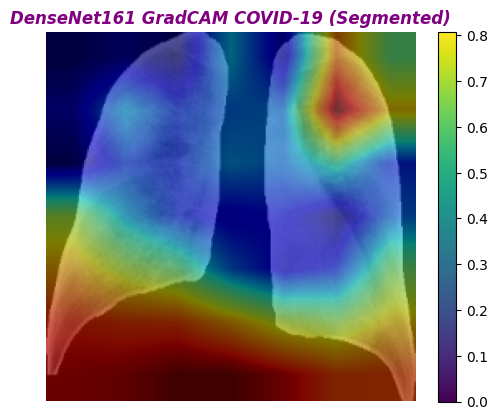

In [ ]:
fig, ax = plt.subplots()

heatmap = ax.imshow(image_numpy)

ax.imshow(cam_map_normalized, cmap='jet', alpha=0.5, interpolation='bilinear')
plt.colorbar(heatmap, fraction=0.06, pad=0.046)
plt.title("DenseNet161 GradCAM COVID-19 (Segmented)", color='purple', weight='bold', style='oblique')
ax.axis('off')

plt.show()


In [ ]:
pneumonia_1 = X_test[26]
pneumonia_1 = torch.from_numpy(pneumonia_1)
pneumonia_1 = pneumonia_1.type(torch.FloatTensor)
pneumonia_1 = torch.unsqueeze(pneumonia_1, dim=0).permute(0,3,1,2)

In [ ]:
from pytorch_grad_cam import GradCAM

target_layer = [model_dn161.features[-1]]

cam = GradCAM(model=model_dn161, target_layers=target_layer)

cam_map = cam(input_tensor=pneumonia_1, eigen_smooth=True, aug_smooth=True)

print(cam_map)

[[[0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  ...
  [0.21796231 0.21796231 0.21796231 ... 0.         0.         0.        ]
  [0.21796231 0.21796231 0.21796231 ... 0.         0.         0.        ]
  [0.21796231 0.21796231 0.21796231 ... 0.         0.         0.        ]]]


In [ ]:
print(type(cam_map))
print(cam_map.shape)
cam_map = np.reshape(cam_map, (224,224,1))
print(cam_map.shape)

<class 'numpy.ndarray'>
(1, 224, 224)
(224, 224, 1)


In [ ]:
image_numpy = torch.squeeze(pneumonia_1, dim=0).permute(1,2,0).numpy()
print(type(image_numpy), image_numpy.shape)

<class 'numpy.ndarray'> (224, 224, 3)


In [ ]:
import matplotlib.pyplot as plt

cam_map_normalized = (cam_map - np.min(cam_map)) / (np.max(cam_map) - np.min(cam_map))

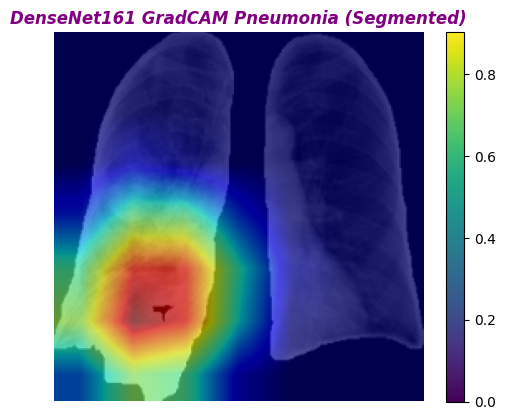

In [ ]:
fig, ax = plt.subplots()

heatmap = ax.imshow(image_numpy)

ax.imshow(cam_map_normalized, cmap='jet', alpha=0.6, interpolation='bilinear')
plt.colorbar(heatmap, fraction=0.06, pad=0.046)
plt.title("DenseNet161 GradCAM Pneumonia (Segmented)", color='purple', weight='bold', style='oblique')
ax.axis('off')

plt.show()


In [ ]:
normal_1 = X_test[44]
normal_1 = torch.from_numpy(normal_1)
normal_1 = normal_1.type(torch.FloatTensor)
normal_1 = torch.unsqueeze(normal_1, dim=0).permute(0,3,1,2)

In [ ]:
from pytorch_grad_cam import GradCAM

target_layer = [model_rn18.layer4[-1]]

cam = GradCAM(model=model_rn18, target_layers=target_layer)

cam_map = cam(input_tensor=normal_1, eigen_smooth=True, aug_smooth=True)

print(cam_map)

[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]


In [ ]:
print(type(cam_map))
print(cam_map.shape)
cam_map = np.reshape(cam_map, (224,224,1))
print(cam_map.shape)

<class 'numpy.ndarray'>
(1, 224, 224)
(224, 224, 1)


In [ ]:
image_numpy = torch.squeeze(normal_1, dim=0).permute(1,2,0).numpy()
print(type(image_numpy), image_numpy.shape)

<class 'numpy.ndarray'> (224, 224, 3)


In [ ]:
import matplotlib.pyplot as plt

cam_map_normalized = (cam_map - np.min(cam_map)) / (np.max(cam_map) - np.min(cam_map))

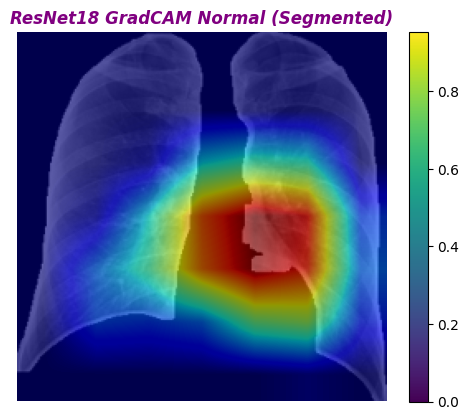

In [ ]:
fig, ax = plt.subplots()

heatmap = ax.imshow(image_numpy)

ax.imshow(cam_map_normalized, cmap='jet', alpha=0.6, interpolation='bilinear')
plt.colorbar(heatmap, fraction=0.06, pad=0.046)
plt.title("ResNet18 GradCAM Normal (Segmented)", color='purple', weight='bold', style='oblique')
ax.axis('off')

plt.show()


In [ ]:
covid_1 = X_test[25]
covid_1 = torch.from_numpy(covid_1)
covid_1 = covid_1.type(torch.FloatTensor)
covid_1 = torch.unsqueeze(covid_1, dim=0).permute(0,3,1,2)

In [ ]:
from pytorch_grad_cam import GradCAM

target_layer = [model_rn18.layer4[-1]]

cam = GradCAM(model=model_rn18, target_layers=target_layer)

cam_map = cam(input_tensor=covid_1, eigen_smooth=True, aug_smooth=True)

print(cam_map)

[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]


In [ ]:
print(type(cam_map))
print(cam_map.shape)
cam_map = np.reshape(cam_map, (224,224,1))
print(cam_map.shape)

<class 'numpy.ndarray'>
(1, 224, 224)
(224, 224, 1)


In [ ]:
image_numpy = torch.squeeze(covid_1, dim=0).permute(1,2,0).numpy()
print(type(image_numpy), image_numpy.shape)

<class 'numpy.ndarray'> (224, 224, 3)


In [ ]:
import matplotlib.pyplot as plt

cam_map_normalized = (cam_map - np.min(cam_map)) / (np.max(cam_map) - np.min(cam_map))

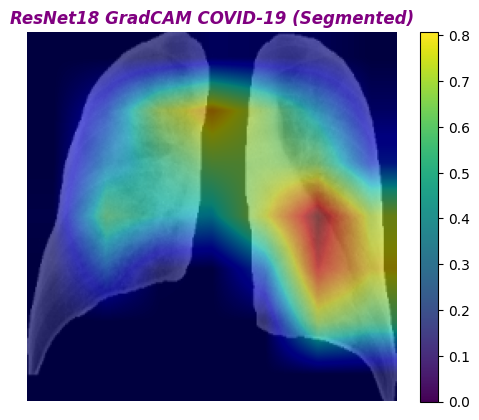

In [ ]:
fig, ax = plt.subplots()

heatmap = ax.imshow(image_numpy)

ax.imshow(cam_map_normalized, cmap='jet', alpha=0.5, interpolation='bilinear')
plt.colorbar(heatmap, fraction=0.06, pad=0.046)
plt.title("ResNet18 GradCAM COVID-19 (Segmented)", color='purple', weight='bold', style='oblique')
ax.axis('off')

plt.show()


In [ ]:
pneumonia_1 = X_test[26]
pneumonia_1 = torch.from_numpy(pneumonia_1)
pneumonia_1 = pneumonia_1.type(torch.FloatTensor)
pneumonia_1 = torch.unsqueeze(pneumonia_1, dim=0).permute(0,3,1,2)

In [ ]:
from pytorch_grad_cam import GradCAM

target_layer = [model_rn18.layer4[-1]]

cam = GradCAM(model=model_rn18, target_layers=target_layer)

cam_map = cam(input_tensor=pneumonia_1, eigen_smooth=True, aug_smooth=True)

print(cam_map)

[[[0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  ...
  [0.20606528 0.20606528 0.20606528 ... 0.         0.         0.        ]
  [0.20606528 0.20606528 0.20606528 ... 0.         0.         0.        ]
  [0.20606528 0.20606528 0.20606528 ... 0.         0.         0.        ]]]


In [ ]:
print(type(cam_map))
print(cam_map.shape)
cam_map = np.reshape(cam_map, (224,224,1))
print(cam_map.shape)

<class 'numpy.ndarray'>
(1, 224, 224)
(224, 224, 1)


In [ ]:
image_numpy = torch.squeeze(pneumonia_1, dim=0).permute(1,2,0).numpy()
print(type(image_numpy), image_numpy.shape)

<class 'numpy.ndarray'> (224, 224, 3)


In [ ]:
import matplotlib.pyplot as plt

cam_map_normalized = (cam_map - np.min(cam_map)) / (np.max(cam_map) - np.min(cam_map))

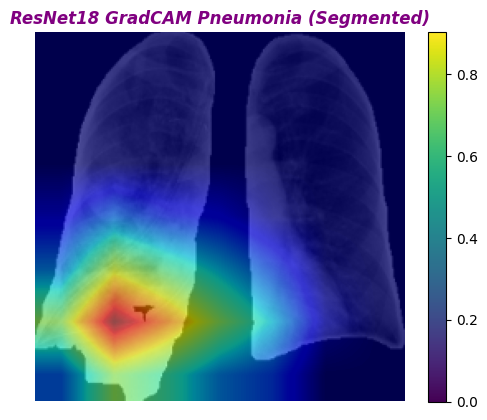

In [ ]:
fig, ax = plt.subplots()

heatmap = ax.imshow(image_numpy)

ax.imshow(cam_map_normalized, cmap='jet', alpha=0.6, interpolation='bilinear')
plt.colorbar(heatmap, fraction=0.06, pad=0.046)
plt.title("ResNet18 GradCAM Pneumonia (Segmented)", color='purple', weight='bold', style='oblique')
ax.axis('off')

plt.show()


In [ ]:
normal_1 = X_test[44]
normal_1 = torch.from_numpy(normal_1)
normal_1 = normal_1.type(torch.FloatTensor)
normal_1 = torch.unsqueeze(normal_1, dim=0).permute(0,3,1,2)

In [ ]:
from pytorch_grad_cam import GradCAM

target_layer = [model_rn34.layer4[-1]]

cam = GradCAM(model=model_rn34, target_layers=target_layer)

cam_map = cam(input_tensor=normal_1, eigen_smooth=True, aug_smooth=True)

print(cam_map)

[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]


In [ ]:
print(type(cam_map))
print(cam_map.shape)
cam_map = np.reshape(cam_map, (224,224,1))
print(cam_map.shape)

<class 'numpy.ndarray'>
(1, 224, 224)
(224, 224, 1)


In [ ]:
image_numpy = torch.squeeze(normal_1, dim=0).permute(1,2,0).numpy()
print(type(image_numpy), image_numpy.shape)

<class 'numpy.ndarray'> (224, 224, 3)


In [ ]:
import matplotlib.pyplot as plt

cam_map_normalized = (cam_map - np.min(cam_map)) / (np.max(cam_map) - np.min(cam_map))

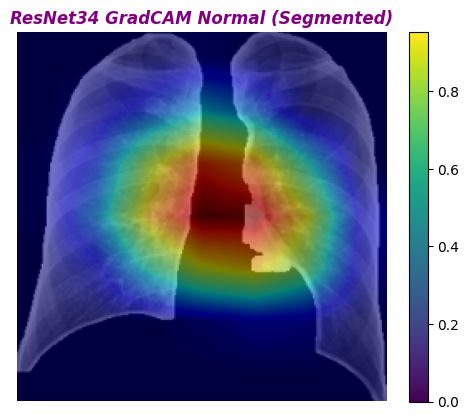

In [ ]:
fig, ax = plt.subplots()

heatmap = ax.imshow(image_numpy)

ax.imshow(cam_map_normalized, cmap='jet', alpha=0.5, interpolation='bilinear')
plt.colorbar(heatmap, fraction=0.06, pad=0.046)
plt.title("ResNet34 GradCAM Normal (Segmented)", color='purple', weight='bold', style='oblique')
ax.axis('off')

plt.show()


In [ ]:
covid_1 = X_test[25]
covid_1 = torch.from_numpy(covid_1)
covid_1 = covid_1.type(torch.FloatTensor)
covid_1 = torch.unsqueeze(covid_1, dim=0).permute(0,3,1,2)

In [ ]:
from pytorch_grad_cam import GradCAM

target_layer = [model_rn34.layer4[-1]]

cam = GradCAM(model=model_rn34, target_layers=target_layer)

cam_map = cam(input_tensor=covid_1, eigen_smooth=True, aug_smooth=True)

print(cam_map)

[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]


In [ ]:
print(type(cam_map))
print(cam_map.shape)
cam_map = np.reshape(cam_map, (224,224,1))
print(cam_map.shape)

<class 'numpy.ndarray'>
(1, 224, 224)
(224, 224, 1)


In [ ]:
image_numpy = torch.squeeze(covid_1, dim=0).permute(1,2,0).numpy()
print(type(image_numpy), image_numpy.shape)

<class 'numpy.ndarray'> (224, 224, 3)


In [ ]:
import matplotlib.pyplot as plt

cam_map_normalized = (cam_map - np.min(cam_map)) / (np.max(cam_map) - np.min(cam_map))

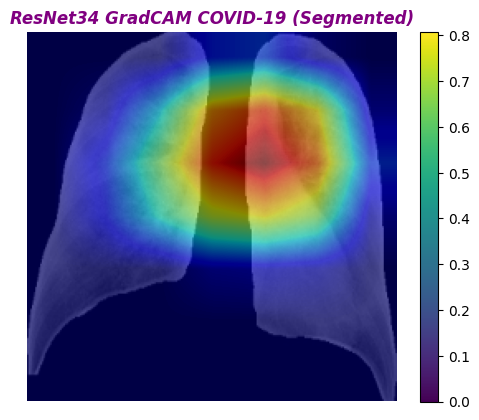

In [ ]:
fig, ax = plt.subplots()

heatmap = ax.imshow(image_numpy)

ax.imshow(cam_map_normalized, cmap='jet', alpha=0.55, interpolation='bilinear')
plt.colorbar(heatmap, fraction=0.06, pad=0.046)
plt.title("ResNet34 GradCAM COVID-19 (Segmented)", color='purple', weight='bold', style='oblique')
ax.axis('off')

plt.show()


In [ ]:
pneumonia_1 = X_test[26]
pneumonia_1 = torch.from_numpy(pneumonia_1)
pneumonia_1 = pneumonia_1.type(torch.FloatTensor)
pneumonia_1 = torch.unsqueeze(pneumonia_1, dim=0).permute(0,3,1,2)

In [ ]:
from pytorch_grad_cam import GradCAM

target_layer = [model_rn34.layer4[-1]]

cam = GradCAM(model=model_rn34, target_layers=target_layer)

cam_map = cam(input_tensor=pneumonia_1, eigen_smooth=True, aug_smooth=True)

print(cam_map)

[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]


In [ ]:
print(type(cam_map))
print(cam_map.shape)
cam_map = np.reshape(cam_map, (224,224,1))
print(cam_map.shape)

<class 'numpy.ndarray'>
(1, 224, 224)
(224, 224, 1)


In [ ]:
image_numpy = torch.squeeze(pneumonia_1, dim=0).permute(1,2,0).numpy()
print(type(image_numpy), image_numpy.shape)

<class 'numpy.ndarray'> (224, 224, 3)


In [ ]:
import matplotlib.pyplot as plt

cam_map_normalized = (cam_map - np.min(cam_map)) / (np.max(cam_map) - np.min(cam_map))

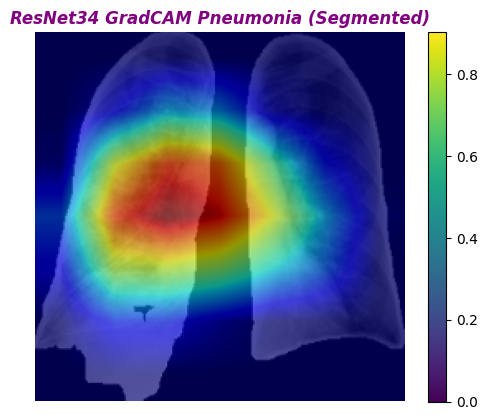

In [ ]:
fig, ax = plt.subplots()

heatmap = ax.imshow(image_numpy)

ax.imshow(cam_map_normalized, cmap='jet', alpha=0.6, interpolation='bilinear')
plt.colorbar(heatmap, fraction=0.06, pad=0.046)
plt.title("ResNet34 GradCAM Pneumonia (Segmented)", color='purple', weight='bold', style='oblique')
ax.axis('off')

plt.show()
